In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import sympy as sy
from sympy import Symbol, solve
import random
from tqdm import tqdm

c:\Users\shins\Anaconda3\envs\HyperImaging\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device='cpu'
device='cuda'

#### Bring World Coordinate w.r.t projector view

In [3]:
# XYZ_proj = np.load('./xyz_proj.npy')

In [4]:
# XYZ_proj.shape

#### Projector sensor coordinate

In [5]:
# proj params
focal_length_proj = 8e-3 # proj intrinsic * pitch
sensor_diag_proj = 5.842e-3
sensor_width_proj = np.sin(np.arctan2(720, 1280))*sensor_diag_proj 
N_proj = 720
R,C = 720, 720
proj_pitch = sensor_width_proj / N_proj

# proj sensor x,y,z
xs = torch.linspace(0, R-1, steps= R)
ys = torch.linspace(0, C-1, steps=C)
c, r = torch.meshgrid(xs, ys, indexing= 'ij')

In [6]:
# plt.figure(figsize=(10,5))
# plt.subplot(121), plt.imshow(r), plt.colorbar()
# plt.subplot(122), plt.imshow(c), plt.colorbar()

In [7]:
# proj x,y,z to world coord
x_c, y_c = (r-N_proj/2)*proj_pitch, (c-N_proj/2)*proj_pitch

z_c = torch.zeros_like(x_c)
z_c[:] = -focal_length_proj

# (0,0,0) proj_sensor_center
proj_sensor_cen = torch.zeros(size=(4,1))
proj_sensor_cen[3,0] = 1

In [8]:
# reshape to 720*720
x_c,y_c,z_c = x_c.flatten(), y_c.flatten(), z_c.flatten() # 720*720

In [9]:
# fig = plt.figure()
# ax = fig.add_subplot(projection = '3d')

# xs = x_c[:]
# ys = y_c[:]
# zs = z_c[:]

# ax.scatter(xs,ys,zs, marker = 'o')

In [10]:
# make xyz1 vector
xyz1 = torch.stack((x_c,y_c,z_c, torch.ones_like(x_c)), dim = 1).transpose(0,1)

#### Create diffraction gratings extrinsic matrix

In [11]:
# rotation, translation matrix
extrinsic_proj_real = torch.zeros((3,4))

# rotation
rot = torch.tensor([1,1,1])
extrinsic_proj_real[0,0] = rot[0]
extrinsic_proj_real[1,1] = rot[1]
extrinsic_proj_real[2,2] = rot[2]

# translate
trans = torch.tensor([0,0,10*1e-3])
extrinsic_proj_real[0,3] = -trans[0]
extrinsic_proj_real[1,3] = -trans[1]
extrinsic_proj_real[2,3] = -trans[2]

In [12]:
# change projector sensor to diffraction gratings coordinate
proj_sensor_dg = extrinsic_proj_real@xyz1

In [13]:
# fig = plt.figure()
# ax = fig.add_subplot(projection = '3d')

# xs = proj_sensor_dg[0,:]
# ys = proj_sensor_dg[1,:]
# zs = proj_sensor_dg[2,:]

# ax.scatter(xs,ys,zs, marker = 'o')

In [14]:
# change center to dg coordinate
proj_sensor_cen_dg = extrinsic_proj_real@proj_sensor_cen

In [15]:
# incident light Direction vectors
incident_dir = proj_sensor_cen_dg[:] - proj_sensor_dg[:,:]

In [16]:
# normal vector, aplha, beta vector
n_vec = torch.tensor([[0,0,1]])
alpha_vec = torch.tensor([[1,0,0]])
beta_vec = torch.tensor([[0,1,0]])

#### XYZ w.r.t. dg

In [17]:
# ones = torch.ones(size=(1, XYZ_proj.shape[1]))
# ones.shape

# XYZ_proj_t = torch.from_numpy(XYZ_proj).float()

# XYZ1 = torch.cat((XYZ_proj_t, ones), dim=0)

# XYZ_dg = extrinsic_proj_real@XYZ1

#### Incident direction unit vector

In [18]:
# making to unit vector
x, y, z = incident_dir[0,:], incident_dir[1,:], incident_dir[2,:]
norm = np.sqrt(x**2+y**2+z**2)

# incident light unit direction vector
incident_dir_unit = incident_dir[:,:] / norm[:]

In [19]:
# find intersection points

def find_intersection(proj_sensor_cen_dg, incident_dir_unit):
    a = torch.zeros_like(incident_dir_unit)

    for i in range(len(incident_dir_unit[0])):
        t = -proj_sensor_cen_dg[2,0]/incident_dir_unit[2,i]
        a[:,i] = t*incident_dir_unit[:,i] + proj_sensor_cen_dg[:,0]
    
    return a

intersection_points = find_intersection(proj_sensor_cen_dg,incident_dir_unit)

#### Intersected points (gratings plane and incident light vector)

In [20]:
# intersected points

intersection_points.shape
intersection_points = intersection_points.reshape(3,R,C)

In [21]:
# fig = plt.figure()
# ax = fig.add_subplot(projection = '3d')

# xs = intersection_points[0,:,:]
# ys = intersection_points[1,:,:]
# zs = intersection_points[2,:,:]

# ax.scatter(xs,ys,zs, marker = 'o')

In [22]:
# check if random dir vector is perpendicular to (0,0,1)
from random import randint

a,b,c,d = randint(0,720),  randint(0,720),  randint(0,720),  randint(0,720) 
np.dot((intersection_points[:,a,b] - intersection_points[:,c,d]), torch.tensor([0,0,1]))

0.0

#### alpha_i and beta_i

cosine of alpha-axis and incident light unit direction vector

cosine of beta-axis and incident light unit direction vector

In [23]:
# alpha_i lefts only x coords
alpha_i = incident_dir_unit[0,:]

# beta_i lefts only y coords
beta_i = incident_dir_unit[1,:]

In [24]:
def get_alpha_m(m, alpha_i, lmbda):
    d = (1/500)*1e-3
    alpha_m = - m*lmbda/d + alpha_i
    
    return alpha_m

def get_beta_m(m, beta_i):
    beta_m = beta_i

    return beta_m

def get_z_m(alpha_m, beta_m):
    z = np.sqrt(1 - alpha_m**2 - beta_m**2)

    return z

#### alpha_m and beta_m

In [25]:
m = 1

lmb = list(np.linspace(450, 700, 11)*1e-9)

alpha_m_list = []
beta_m_list = []
z_list = []

for i in range(len(lmb)):
    alpha_m = get_alpha_m(alpha_i=alpha_i, m =m, lmbda=lmb[i])
    beta_m = get_beta_m(beta_i=beta_i, m=m)
    z = get_z_m(alpha_m, beta_m)

    alpha_m_list.append(alpha_m)
    beta_m_list.append(beta_m)
    z_list.append(z)

In [26]:
alpha_m = alpha_m.reshape(R,C)
beta_m = beta_m.reshape(R,C)
z = z.reshape(R,C)

#### Diffracted light unit direction vector

In [27]:
# diffracted unit vector
diffracted_dir_unit = torch.stack((alpha_m,beta_m,z), dim = 0)

#### Diffracted light starting from intersected points

In [28]:
# diffracted light line segment
diffracted_unit = diffracted_dir_unit + intersection_points

In [29]:
# diffracted_dir_unit_np = diffracted_dir_unit.numpy()
# intersection_points_np = intersection_points.numpy()

In [30]:
# check if these meet

# from sympy import Symbol, solve

# t = Symbol('t')
# s = Symbol('s')

# eq0 = t * diffracted_dir_unit_np[0,0,0] + intersection_points_np[0,0,0] - s * diffracted_dir_unit_np[0,12,100] - intersection_points_np[0,12,100]
# eq1 = t * diffracted_dir_unit_np[1,0,0] + intersection_points_np[1,0,0] - s * diffracted_dir_unit_np[1,12,100] - intersection_points_np[1,12,100]
# eq2 = t * diffracted_dir_unit_np[2,0,0] + intersection_points_np[2,0,0] - s * diffracted_dir_unit_np[2,12,100] - intersection_points_np[2,12,100]
# 00
# solve((eq0,eq1, eq2) ,dict = True)

#### XYZ to rc

In [31]:
# # fixed variable
# # groove
# d = 2*1e-6

# # projector censor w.r.t dg view
# t1, t2, t3 = proj_sensor_cen_dg[0], proj_sensor_cen_dg[1], proj_sensor_cen_dg[2]

# # diffracted order
# m = 1

In [32]:
# a = Symbol('a')
# b = Symbol('b')
# c = Symbol('c')

# for i in range(1):
#     X, Y, Z = XYZ_dg[0,i], XYZ_dg[1,i], XYZ_dg[2,i]
    
#     for l in range(400,401):
#         eqtn0 = a**2 + b**2 + c**2 - 1
#         eqtn1 =  a*(Y-t2) + b*((2*m*l)/(c*d) + t1 - X) + (m*l*t2)/d - m*l*Y/d
#         eqtn2 =  (t2 + Z*b/c - Y)*((1-(m*l/d - a)**2 - b**2)**(1/2)) + b*t3

#         solve((eqtn0,eqtn1, eqtn2) ,dict = True)

#### Visualization

In [33]:
lmb = list(np.linspace(400, 700, 11)*1e-9)
colors = np.array([plt.cm.rainbow(a) for a in np.linspace(0.0, 1.0, len(lmb))])
colors_px = np.array([plt.cm.viridis(a) for a in np.linspace(0.0, 1.0, R*C)])

In [34]:
print(alpha_m.shape, beta_m.shape, z.shape, proj_sensor_dg.shape, intersection_points.shape)

# alpha_m_r = alpha_m.reshape(R*C)
# beta_m_r = beta_m.reshape(R*C)
# z_r = z.reshape(R*C)
intersection_points_r = intersection_points.reshape(3,R*C)

torch.Size([720, 720]) torch.Size([720, 720]) torch.Size([720, 720]) torch.Size([3, 518400]) torch.Size([3, 720, 720])


In [35]:
# # %%

# # intersected points 에서 정방향의 diffracted dir그리기
# def draw_setup(elev,azi):
#     fig = plt.figure(figsize=(10,5))
#     ax = plt.axes(projection = '3d')
#     ax.set_xlim([-0.005,0.005])
#     ax.set_ylim([-0.005,0.005])
#     ax.set_zlim([-0.018,0.01])

#     for j in range(len(lmb)):
#         alpha_m = alpha_m_list[j]
#         beta_m = beta_m_list[j]
#         z = z_list[j]

#         for i in range(0,R*C,10000):
#         # for i in range(0,720,100):  
#             start = [intersection_points_r[0,i],intersection_points_r[1,i],intersection_points_r[2,i]]

#             # intersected points
#             ax.scatter(start[0],start[1],start[2], marker = 'o', color = 'black', s = 1)

#             # 정방향
#             scale =  1/10
#             # diffracted ray
#             X_d = [start[0], start[0] + scale*alpha_m[i]]
#             Y_d = [start[1], start[1] + scale*beta_m[i]]
#             Z_d = [start[2], start[2] + scale*z[i]]
#             ax.plot(X_d,Y_d,Z_d, color = colors[j], linewidth = 0.25)
#             #ax.plot(start[0], start[1], start[2], start[0] + 1/40*alpha_m[i,j], start[1] + 1/40*beta_m[i,j], start[2] +1/40*z[i,j])

#             # 역방향
#             scale =  -1/10
#             # diffracted ray
#             X_d = [start[0], start[0] + scale*alpha_m[i]]
#             Y_d = [start[1], start[1] + scale*beta_m[i]]
#             Z_d = [start[2], start[2] + scale*z[i]]
#             ax.plot(X_d,Y_d,Z_d, color = colors[j], linewidth = 0.1, linestyle = 'dashed')

#             # projector sensor points
#             ax.scatter(proj_sensor_dg[0,i], proj_sensor_dg[1,i], proj_sensor_dg[2,i], marker= 'o', color = 'black', s= 1)

#             start_proj = [proj_sensor_dg[0,i], proj_sensor_dg[1,i], proj_sensor_dg[2,i]]
#             # incident ray
#             X_i = [start_proj[0], start[0]]
#             Y_i = [start_proj[1], start[1]]
#             Z_i = [start_proj[2], start[2]]
#             ax.plot(X_i,Y_i,Z_i, color = 'black', linewidth = 0.25)

#             ax.scatter(proj_sensor_cen_dg[0], proj_sensor_cen_dg[1], proj_sensor_cen_dg[2], marker= 'o', c = 'black', s = 1)

#             ax.set_xlabel('x-axis')
#             ax.set_ylabel('y-axis')
#             ax.set_zlabel('z-axis')

#     ax.view_init(elev, azi)


# # draw_setup(90, 0)
# draw_setup(0, 0)
# # draw_setup(0, 90)
# draw_setup(45, 45)
# draw_setup(0, 90)

#### 특정 lambda / 파장 값

lmb_ind = 5

alpha_m = alpha_m_list[lmb_ind]

beta_m = beta_m_list[lmb_ind]

z = z_list[lmb_ind]

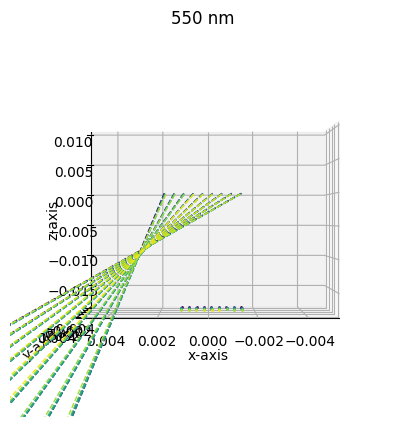

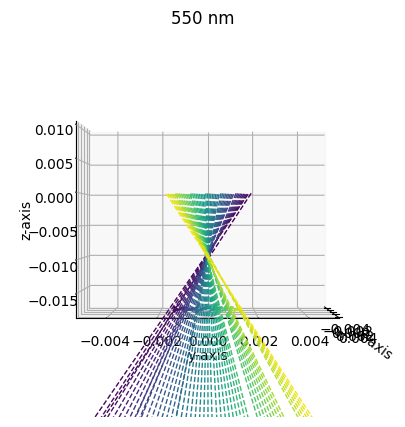

In [36]:
# check rays for a specific wavelength
def draw_for_wl(elev, azi, lmb_ind):
    alpha_m = alpha_m_list[lmb_ind]
    beta_m = beta_m_list[lmb_ind]
    z = z_list[lmb_ind]
    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection = '3d')
    ax.set_xlim([-0.005,0.005])
    ax.set_ylim([-0.005,0.005])
    ax.set_zlim([-0.018,0.01])

    for i in range(0,R*C,10000):
        start = [intersection_points_r[0,i],intersection_points_r[1,i],intersection_points_r[2,i]]

        # 역방향
        scale =  -1/10
        # diffracted ray
        X_d = [start[0], start[0] + scale*alpha_m[i]]
        Y_d = [start[1], start[1] + scale*beta_m[i]]
        Z_d = [start[2], start[2] + scale*z[i]]
        ax.plot(X_d,Y_d,Z_d, color = colors_px[i], linewidth = 1, linestyle = 'dashed')

        # projector sensor points
        ax.scatter(proj_sensor_dg[0,i], proj_sensor_dg[1,i], proj_sensor_dg[2,i], marker= 'o', color = colors_px[i], s= 1)

    plt.title('%d nm'%int(lmb[lmb_ind]*1e9))

    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

    ax.view_init(elev, azi)

draw_for_wl(0,90,5)
draw_for_wl(0,0,5)

#### below is the pseudocode for obtaining the virtual projector parameters for a wavelength and a diffraction order 

In [37]:
a = torch.tensor([1])
b = torch.tensor([2])

torch.cat((a,b), dim = 0)

tensor([1, 2])

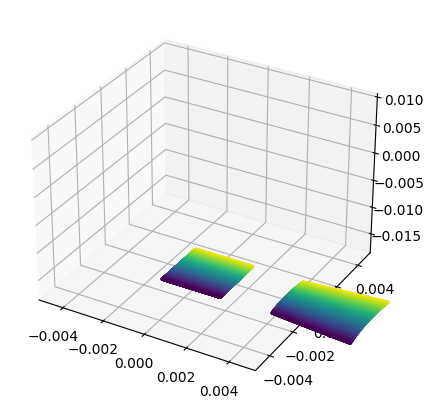

In [38]:
# build virtual projector plane
# real proj 와 평행한 z=0 

# sensor_X_ = torch.tensor([])
# sensor_Y = torch.tensor([])
# sensor_Z = torch.tensor([])

def draw_virtual_plane(lmb_ind):
    alpha_m = alpha_m_list[lmb_ind]
    beta_m = beta_m_list[lmb_ind]
    z = z_list[lmb_ind]
    sensor_z = proj_sensor_dg[2,:].mean()  # new sensor's z location

    start = [intersection_points_r[0,:],intersection_points_r[1,:],intersection_points_r[2,:]]

    scale_sensor = (sensor_z-start[2])/z
    sensor_X = start[0] + scale_sensor*alpha_m
    sensor_Y = start[1] + scale_sensor*beta_m
    sensor_Z = start[2] + scale_sensor*z

    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection = '3d')
    ax.set_xlim([-0.005,0.005])
    ax.set_ylim([-0.005,0.005])
    ax.set_zlim([-0.018,0.01])

    ax.scatter(proj_sensor_dg[0,:], proj_sensor_dg[1,:], proj_sensor_dg[2,:], marker= 'o', color = colors_px, s= 1)
    ax.scatter(sensor_X, sensor_Y, sensor_Z, marker= 'o', color=colors_px,  s= 1, alpha=0.1)

    return sensor_X, sensor_Y, sensor_Z

lmb_ind = 5
sensor_X_virtual, sensor_Y_virtual, sensor_Z_virtual = draw_virtual_plane(lmb_ind)

#### intersection points of two random lines

In [39]:
# # intersection points of two random lines

# # direction vector 

# t = Symbol('t')
# s = Symbol('s')

# diffracted_dir_unit = torch.stack((alpha_m,beta_m,z), dim = 0)
# diffracted_dir_unit_np = diffracted_dir_unit.numpy()
# intersection_points_np = intersection_points.reshape(3,R*C).numpy()

In [40]:
# r_num1 = random.randint(0,R*C)
# r_num2 = random.randint(0,R*C)

# eq0 = t * diffracted_dir_unit_np[0,r_num1] + intersection_points_np[0,r_num1] - s * diffracted_dir_unit_np[0,r_num2] - intersection_points_np[0,r_num2]
# eq1 = t * diffracted_dir_unit_np[1,r_num1] + intersection_points_np[1,r_num1] - s * diffracted_dir_unit_np[1,r_num2] - intersection_points_np[1,r_num2]
# eq2 = t * diffracted_dir_unit_np[2,r_num1] + intersection_points_np[2,r_num1] - s * diffracted_dir_unit_np[2,r_num2] - intersection_points_np[2,r_num2]

# Sol = solve((eq0,eq1,eq2),dict = True)

In [41]:
# s,t = Sol[0][s], Sol[0][t]

In [42]:
# point1 = np.array([t * diffracted_dir_unit_np[0,r_num1] + intersection_points_np[0,r_num1], t * diffracted_dir_unit_np[1,r_num1] + intersection_points_np[1,r_num1], t * diffracted_dir_unit_np[2,r_num1] + intersection_points_np[2,r_num1]])
# point2 = np.array([s * diffracted_dir_unit_np[0,r_num2] + intersection_points_np[0,r_num2], s * diffracted_dir_unit_np[1,r_num2] + intersection_points_np[1,r_num2], s * diffracted_dir_unit_np[2,r_num2] + intersection_points_np[2,r_num2]])

In [43]:
# point1[0], point1[1], point1[2] = round(point1[0], 6), round(point1[1], 6), round(point1[2], 6)
# point2[0], point2[1], point2[2] = round(point2[0], 6), round(point2[1], 6), round(point2[2], 6)

In [44]:
# print(point1, point2)

#### find t which makes inner product of line and point P zero

In [45]:
diffracted_dir_unit_r = diffracted_dir_unit.reshape(3, R*C)
diffracted_dir_unit_r.shape

torch.Size([3, 518400])

In [46]:
# intersection_points_r_cuda = intersection_points_r[:,::259200].cuda()
# diffracted_dir_unit_r_cuda = diffracted_dir_unit_r[:,::259200].cuda()
intersection_points_r_cuda = intersection_points_r[:,::172800].to(device)
diffracted_dir_unit_r_cuda = diffracted_dir_unit_r[:,::172800].to(device)
# diffracted_dir_unit_r_cuda = diffracted_dir_unit_r.cuda()
# intersection_points_r_cuda = intersection_points_r.cuda()

In [47]:
diffracted_dir_unit_r_cuda

tensor([[-0.1765, -0.1741, -0.1741],
        [ 0.1735,  0.0586, -0.0586],
        [ 0.9689,  0.9830,  0.9830]], device='cuda:0')

In [48]:
intersection_points_r_cuda

tensor([[ 0.0018,  0.0018,  0.0018],
        [ 0.0018,  0.0006, -0.0006],
        [ 0.0000,  0.0000,  0.0000]], device='cuda:0')

#### numpy practice

In [49]:
# a = np.array([[1,2,3],[4,5,6]]).transpose(1,0)
# print(a.shape)

# b = np.array([[1,3,5],[2,4,6]]).transpose(1,0) # unit vector 1,3,5 & 2,4,6
# b.shape

# print(a*b)
# print(np.sum(a*b, axis = 0))

In [50]:
# a = np.array([[1,2,3]]).transpose(1,0)
# print(a.shape)

# b = np.array([[1,2,3],[4,5,6]]).transpose(1,0)
# print(b.shape)

# c = np.array([[1,3,5],[2,4,6]]).transpose(1,0) # unit vector 1,3,5 & 2,4,6

# b-a

#### Find foot perpendicular

In [51]:
# xyz = torch.tensor([[0.003], [0.0], [-0.01]])
# xyz = torch.tensor([[ 3.3733e-03], [-4.3081e-05], [-8.7944e-03]])
# xyz = torch.tensor([[3], [3], [3]])
# dir_vec = torch.tensor([[1,1,2],[-1,1,1]]).transpose(1,0)
# int_point = torch.tensor([[-1,0,1],[0,0,1]]).transpose(1,0)
# int_point.shape

In [52]:
# size = torch.sum(dir_vec*dir_vec, axis = 0)

In [53]:
# size

In [54]:
# size = torch.sum(diffracted_dir_unit_r*diffracted_dir_unit_r,axis = 0)
# print(size.shape)
# if True in (size != 1):
#     print('true is in here')

In [55]:
# t = xyz.transpose(1,0)@diffracted_dir_unit_r - torch.sum(intersection_points_r*diffracted_dir_unit_r, axis=0) # 1,3 * 3,518400 
# t = (xyz.transpose(1,0)@dir_vec - torch.sum(int_point*dir_vec, axis=0))/size
# foot_perpendicular = int_point + t*dir_vec

In [56]:
# foot_perpendicular

In [57]:
# check if inner product is zero
# torch.sum((foot_perpendicular-xyz)*diffracted_dir_unit_r, axis = 0)

In [58]:
# M_foot_perpen = foot_perpendicular - xyz
# mul = M_foot_perpen*M_foot_perpen
# mul

In [59]:
# sum = torch.sum(M_foot_perpen*M_foot_perpen, axis = 0)
# distances = torch.sqrt(torch.sum(M_foot_perpen*M_foot_perpen, axis = 0))
# print(sum, distances)

In [60]:
# mean = torch.mean(distances)
# mean

#### Least-square nearest point to multiple lines

In [64]:
def intersect(P,dir):
    """P and dir are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    # generate the array of all projectors
    projs = np.eye(dir.shape[1]) - dir[:,:,np.newaxis]*dir[:,np.newaxis]  # I - n*n.T
    # see fig. 1 

    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P[:,:,np.newaxis]).sum(axis=0)

    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q,rcond=None)[0]

    return p

p = intersection_points_r.data.numpy().T
d = diffracted_dir_unit_r.data.numpy().T
xyz_param_cpu = intersect(p,d)
xyz_param_cpu = torch.tensor(xyz_param_cpu, dtype=torch.float32)

In [66]:
print(xyz_param_cpu)

tensor([[ 3.3327e-03],
        [ 1.6814e-07],
        [-8.6935e-03]])


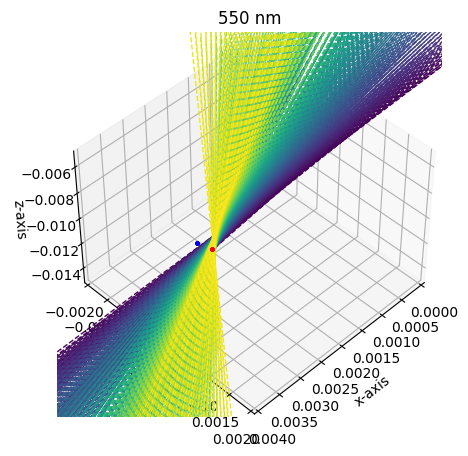

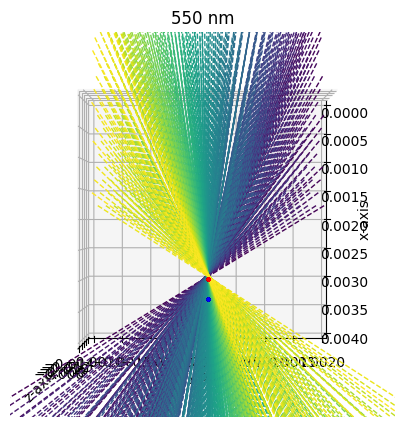

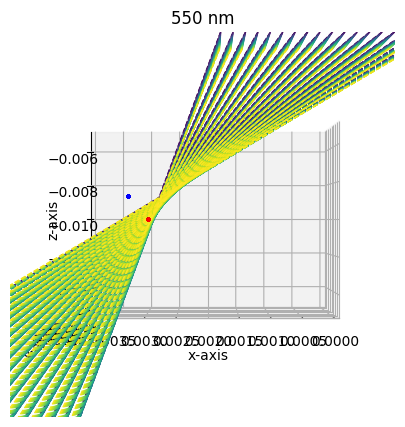

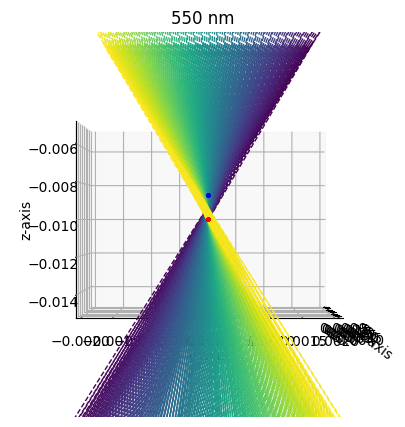

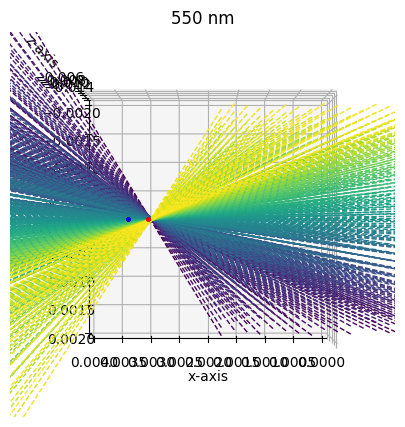

In [70]:
xyz_initial = torch.tensor([[0.003], [0.0], [-0.01]])

def draw_for_wl_with_point(elev, azi, lmb_ind):
    alpha_m = alpha_m_list[lmb_ind]
    beta_m = beta_m_list[lmb_ind]
    z = z_list[lmb_ind]
    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection = '3d')
    # ax.set_xlim([-0.005,0.005])
    # ax.set_ylim([-0.005,0.005])
    # ax.set_zlim([-0.018,0.01])

    ax.set_xlim([0.0,0.004])
    ax.set_ylim([-0.002,0.002])
    ax.set_zlim([-0.015,-0.005])

    for i in range(0,R*C,1000):
    # for i in range(0,R*C,10000):
        start = [intersection_points_r[0,i],intersection_points_r[1,i],intersection_points_r[2,i]]

        # 역방향
        scale =  -1/10
        # scale = 1
        # diffracted ray
        X_d = [start[0], start[0] + scale*alpha_m[i]]
        Y_d = [start[1], start[1] + scale*beta_m[i]]
        Z_d = [start[2], start[2] + scale*z[i]]
        ax.plot(X_d,Y_d,Z_d, color = colors_px[i], linewidth = 1, linestyle = 'dashed')

        # initial point
        ax.scatter(xyz_initial[0], xyz_initial[1], xyz_initial[2], marker= 'o', color = 'red', s= 2)

        # optimized point
        ax.scatter(xyz_param_cpu[0], xyz_param_cpu[1], xyz_param_cpu[2], marker= 'o', color = 'blue', s= 2)

    plt.title('%d nm'%int(lmb[lmb_ind]*1e9))

    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

    ax.view_init(elev, azi)
    
draw_for_wl_with_point(45,45,5)
draw_for_wl_with_point(90,0,5)
draw_for_wl_with_point(0,90,5)
draw_for_wl_with_point(0,0,5)
draw_for_wl_with_point(90,90,5)

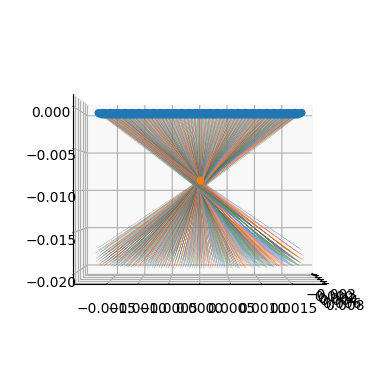

In [ ]:
# %matplotlib ipympl

step = 1000
# fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d') 
ax.scatter3D(p[::step,0], p[::step,1], p[::step,2]) # visualization of intersection points
ax.scatter3D(xyz_param_cpu[0], xyz_param_cpu[1], xyz_param_cpu[2], 'r') # virtual proj center
scale = -2e-2
p2 = p+scale*d

for i in range(0, p.shape[0], step):
    ax.plot([p[i,0], p2[i,0]], [p[i,1], p2[i,1]], [p[i,2], p2[i,2]], linewidth = 0.2)

ax.view_init(0, 0)
plt.show()

#### Optimization

In [101]:
# xyz = torch.tensor([[0.003], [0.0], [-0.01]], dtype=torch.float32, device=device, requires_grad=True)
# # xyz = torch.tensor([[0.01], [0.0], [0.01]], dtype=torch.float32, device='cuda', requires_grad=True)
# xyz_param = torch.nn.Parameter(xyz)

# optimizer = torch.optim.Adam([{'params':xyz_param, 'lr': 1e-3}])
# # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
# #                                         lr_lambda=lambda epoch: 0.95 ** epoch,
# #                                         )
# print(xyz_param)

In [102]:
# loss_list = []
# param_list = []
# iteration = np.arange(0,20000)
# # iteration = np.arange(0,1)

# for iter in tqdm(iteration):
#     t = xyz_param.transpose(1,0)@diffracted_dir_unit_r_cuda - torch.sum(intersection_points_r_cuda*diffracted_dir_unit_r_cuda, axis=0) # 1,3 * 3,518400 
#     # 수선의 발 points 들
#     foot_perpendicular = intersection_points_r_cuda + t*diffracted_dir_unit_r_cuda
#     # print(foot_perpendicular.shape)
#     M_foot_perpen = foot_perpendicular - xyz_param
#     # print(M_foot_perpen.shape)
#     # center로 정한 점과 diffracted된 rays까지의 거리들의 평균
#     distances = torch.sqrt(torch.sum(M_foot_perpen*M_foot_perpen, axis = 0))
#     # print(distances.shape)
#     mean = torch.mean(distances)
#     loss = mean

#     loss_list.append(loss.data.cpu().numpy())

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     # scheduler.step()
    
#     if iter%100 == 0:
#         print('iter:', iter, 'loss:', loss.data.cpu().numpy())
#         print('mean:', mean)
#         # print(xyz_param)
#         # print(t)
#         # print(t.shape)
#         # print(xyz_param)
#         # print(optimizer.param_groups[0]['lr'])

In [104]:
# plt.figure()
# plt.plot(range(len(loss_list)), loss_list)
# plt.show()

In [ ]:
# min = np.min(loss_list)
# idx = loss_list.index(min)
# print(param_list[idx])
# print(loss_list[idx])
# print(loss_list[0])
# print(param_list[0])

In [105]:
# xyz_param_cpu = xyz_param.data.cpu()
# xyz_initial = torch.tensor([[0.003], [0.0], [-0.01]])
# print(xyz_initial, '\n',xyz_param_cpu)

In [106]:
# least = torch.tensor([[ 3.5039e-03],
#         [-1.3794e-05],
#         [-1.0031e-02]])

In [107]:
# def draw_for_wl_with_point(elev, azi, lmb_ind):
#     alpha_m = alpha_m_list[lmb_ind]
#     beta_m = beta_m_list[lmb_ind]
#     z = z_list[lmb_ind]
#     fig = plt.figure(figsize=(10,5))
#     ax = plt.axes(projection = '3d')
#     # ax.set_xlim([-0.005,0.005])
#     # ax.set_ylim([-0.005,0.005])
#     # ax.set_zlim([-0.018,0.01])

#     ax.set_xlim([0.0,0.004])
#     ax.set_ylim([-0.002,0.002])
#     ax.set_zlim([-0.015,-0.005])

#     for i in range(0,R*C,172800):
#     # for i in range(0,R*C,10000):
#         start = [intersection_points_r[0,i],intersection_points_r[1,i],intersection_points_r[2,i]]

#         # 역방향
#         scale =  -1/10
#         # scale = 1
#         # diffracted ray
#         X_d = [start[0], start[0] + scale*alpha_m[i]]
#         Y_d = [start[1], start[1] + scale*beta_m[i]]
#         Z_d = [start[2], start[2] + scale*z[i]]
#         ax.plot(X_d,Y_d,Z_d, color = colors_px[i], linewidth = 1, linestyle = 'dashed')

#         # initial point
#         ax.scatter(xyz_initial[0], xyz_initial[1], xyz_initial[2], marker= 'o', color = 'red', s= 2)

#         # optimized point
#         ax.scatter(least[0], least[1], least[2], marker= 'o', color = 'blue', s= 2)

#     plt.title('%d nm'%int(lmb[lmb_ind]*1e9))

#     ax.set_xlabel('x-axis')
#     ax.set_ylabel('y-axis')
#     ax.set_zlabel('z-axis')

#     ax.view_init(elev, azi)
    
# draw_for_wl_with_point(45,45,5)
# draw_for_wl_with_point(90,0,5)
# draw_for_wl_with_point(0,90,5)
# draw_for_wl_with_point(0,0,5)
# draw_for_wl_with_point(90,90,5)

#### Extrinsic, Intrinsic Matrix
##### Need to define all coords to proj coordinate

optical_center_proj 자체가 diffraction gratings coordinate 위 점이기때문에 이에 대한 conversion이 필요함

In [ ]:
extrinsic_proj_real_toproj = extrinsic_proj_real
extrinsic_proj_real_toproj[:,3] = trans
extrinsic_proj_real_toproj

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0100]])

In [ ]:
ones = torch.tensor([[1]])
xyz_param_cpu1 = torch.cat((xyz_param_cpu, ones), dim = 0)
proj_sensor_cen_dg1 = torch.cat((proj_sensor_cen_dg, ones), dim = 0)

In [ ]:
# rotation, translation matrix
extrinsic_proj_virtual = torch.zeros((4,4))

# rotation
rot = torch.tensor([1,1,1])
extrinsic_proj_virtual[0,0] = rot[0]
extrinsic_proj_virtual[1,1] = rot[1]
extrinsic_proj_virtual[2,2] = rot[2]

# translate
optical_center_virtual = extrinsic_proj_real_toproj@xyz_param_cpu1
optical_center_proj = extrinsic_proj_real_toproj@proj_sensor_cen_dg1

trans = optical_center_virtual - optical_center_proj[:3]
extrinsic_proj_virtual[0,3] = -trans[0]
extrinsic_proj_virtual[1,3] = -trans[1]
extrinsic_proj_virtual[2,3] = -trans[2]
extrinsic_proj_virtual[3,3] = 1

extrinsic_proj_virtual

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00, -3.6334e-03],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00, -1.8755e-05],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00, -9.0156e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
extrinsic_proj_real_toproj

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0100]])

In [ ]:
optical_center_proj

tensor([[0.],
        [0.],
        [0.]])

In [ ]:
optical_center_virtual, sensor_Z_virtual.mean()

(tensor([[3.6334e-03],
         [1.8755e-05],
         [9.0156e-05]]),
 tensor(-0.0180))

#### Intrinsic matrix

sensor_X_virtual, sensor_Y_virtual 자체가 diffraction gratings coordinate 위 점이기때문에 이에 대한 coordinate conversion이 필요함

In [ ]:
focal_length_proj_virtual = (optical_center_virtual[2] - sensor_Z_virtual.mean()).abs()
cx_proj_virtual = sensor_X_virtual.mean() - optical_center_virtual[0]
cy_proj_virtual = sensor_Y_virtual.mean() - optical_center_virtual[1]

# extrinsic_proj_virtual = [rot_proj, optical_center_virtual - optical_center_proj; 0, 0, 0, 1]
intrinsic_proj_virtual = torch.tensor([[focal_length_proj_virtual, 0, cx_proj_virtual], 
                                        [0, focal_length_proj_virtual, cy_proj_virtual],
                                        [0,0,1]])
                                        
dist_proj_virtual = [0, 0, 0, 0, 0] # k1, k2, k3, p1, p2

intrinsic_proj_virtual

tensor([[ 1.8090e-02,  0.0000e+00,  1.9031e-03],
        [ 0.0000e+00,  1.8090e-02, -2.0957e-05],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
sensor_X_real = proj_sensor_dg[0,:]
sensor_Y_real = proj_sensor_dg[1,:]
sensor_Z_real = proj_sensor_dg[2,:]

Text(0.5, 0.98, 'real coordinates')

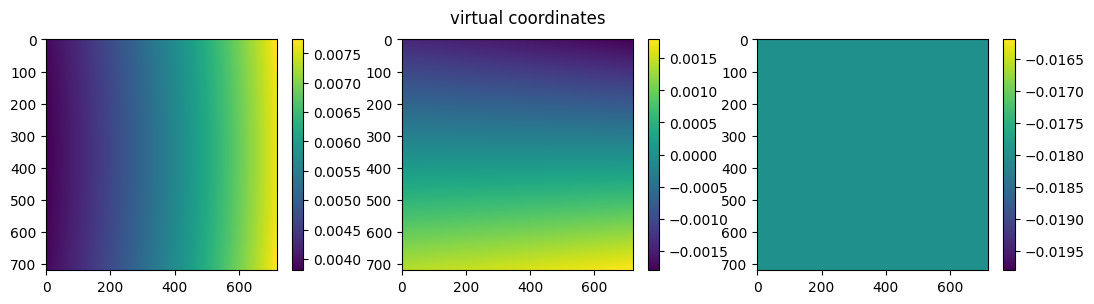

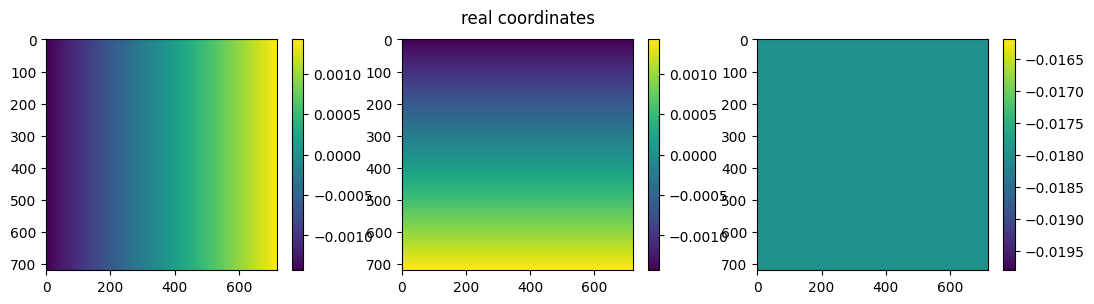

In [ ]:
plt.figure(figsize=(13,3))
plt.subplot(131), plt.imshow(sensor_X_virtual.reshape(R,C))
plt.colorbar()
plt.subplot(132), plt.imshow(sensor_Y_virtual.reshape(R,C))
plt.colorbar()
plt.subplot(133), plt.imshow(sensor_Z_virtual.reshape(R,C))
plt.colorbar()
plt.suptitle('virtual coordinates')

plt.figure(figsize=(13,3))
plt.subplot(131), plt.imshow(sensor_X_real.reshape(R,C))
plt.colorbar()
plt.subplot(132), plt.imshow(sensor_Y_real.reshape(R,C))
plt.colorbar()
plt.subplot(133), plt.imshow(sensor_Z_real.reshape(R,C))
plt.colorbar()
plt.suptitle('real coordinates')

#### save the input/output data into matlab files so that the initial fitting can be done there

In [ ]:
from scipy.io import savemat, loadmat
from os import makedirs
from os.path import exists, join

sensor_X_virtual = sensor_X_virtual.reshape(R,C)
sensor_Y_virtual = sensor_Y_virtual.reshape(R,C)
sensor_X_real = sensor_X_real.reshape(R,C)
sensor_Y_real = sensor_Y_real.reshape(R,C)

dat_path = './dat/'
if not exists(dat_path):
    makedirs(dat_path)
savemat(join(dat_path, 'dispersion_coordinates_m%d_wvl%d.mat'%(m, lmb[lmb_ind]*1e9 )), {'x': sensor_X_virtual.data.cpu().numpy(), 'y':sensor_Y_virtual.data.cpu().numpy(), 'xo': sensor_X_real.data.cpu().numpy(), 'yo': sensor_Y_real.data.cpu().numpy()})

##### run image_formation_dispersion.m

#### load the matlab fitting results

In [ ]:

p = loadmat(join(dat_path, 'param_dispersion_coordinates_m%d_wvl%d.mat'%(m, lmb[lmb_ind]*1e9 )))
p = p['p']


In [ ]:
def distort_func(x, y, p, q, N = 5):
    
    cnt=0
    x_d, y_d = torch.zeros_like(x), torch.zeros_like(y)
    
    for n in range(N+1):
        # for each degree n
        for i in range(n+1):
            # 
            x_d += p[cnt]*(x**(n-i))*(y**(i))
            y_d += q[cnt]*(x**(n-i))*(y**(i))
            cnt += 1
    # x_d = p00 + p10*x + p01*y + p20*(x**2) + p11*x*y + p02*(y**2) + p30*(x**3) + p21*(x**2)*y + p12*x*(y**2) + p03*(y**3) + p40*(x**4) + p31*(x**3)*y + p22*(x**2)*(y**2) + p13*x*(y**3) + p04*(y**4) + p50*(x**5) + p41*(x**4)*y + p32*(x**3)*(y**2) + p23*(x**2)*(y**3) + p14*x*(y**4) + p05*(y**5)
    # y_d = q00 + q10*x + q01*y + q20*(x**2) + q11*x*y + q02*(y**2) + q30*(x**3) + q21*(x**2)*y + q12*x*(y**2) + q03*(y**3) + q40*(x**4) + q31*(x**3)*y + q22*(x**2)*(y**2) + q13*x*(y**3) + q04*(y**4) + q50*(x**5) + q41*(x**4)*y + q32*(x**3)*(y**2) + q23*(x**2)*(y**3) + q14*x*(y**4) + q05*(y**5)

    return x_d, y_d


N_params = 21
# p_dist = torch.zeros((N_patches, 2), dtype=torch.float32, device=device, requires_grad=True)
p_dist = torch.tensor(p, dtype=torch.float32, device=device).T
p_dist.requires_grad=True
sensor_X_virtual = sensor_X_virtual.to(device)
sensor_Y_virtual = sensor_Y_virtual.to(device)
sensor_X_real = sensor_X_real.to(device)
sensor_Y_real = sensor_Y_real.to(device)

sensor_X_virtual_distorted, sensor_Y_virtual_distorted =  distort_func(sensor_X_virtual, sensor_Y_virtual, p_dist[:,0], p_dist[:,1])

reprojection_error_x = (sensor_X_real - sensor_X_virtual_distorted).data.cpu().numpy()
reprojection_error_y = (sensor_Y_real - sensor_Y_virtual_distorted).data.cpu().numpy()
reprojection_error_px = (reprojection_error_x**2 + reprojection_error_y**2)**0.5/proj_pitch

plt.figure()
plt.imshow(reprojection_error_px, cmap='hot', vmin=0, vmax=np.abs(reprojection_error_px).max())
plt.colorbar()
plt.suptitle('error in px')   

Text(0.5, 0.98, 'error in px')

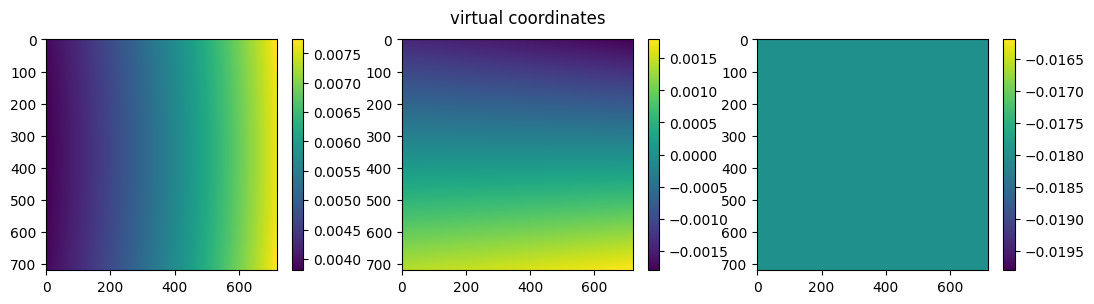

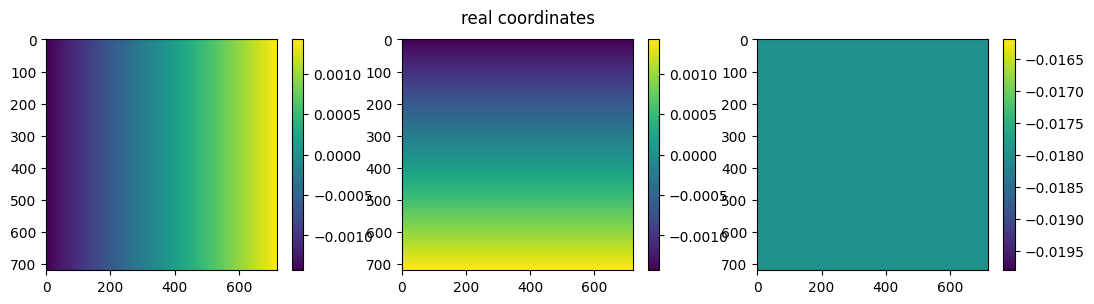

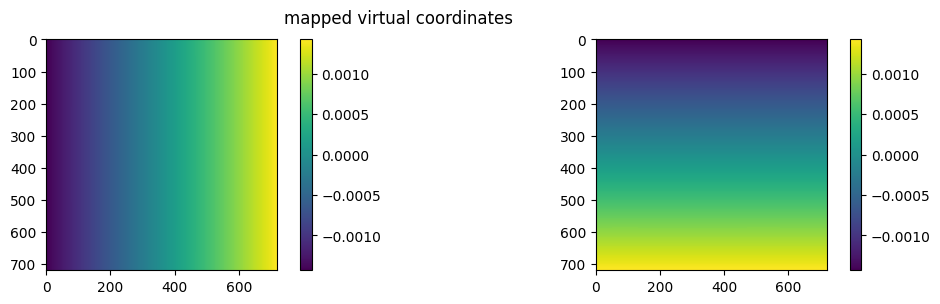

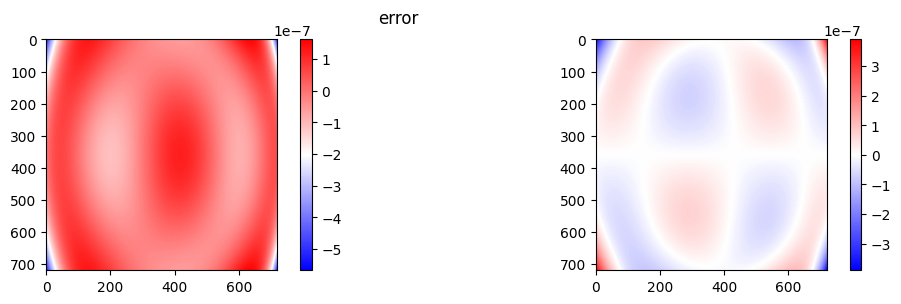

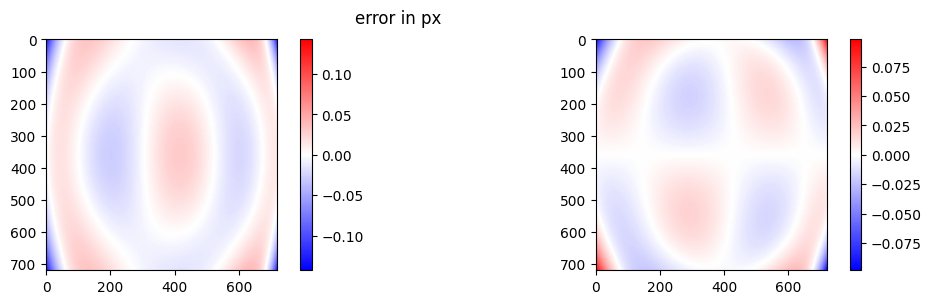

In [ ]:
plt.figure(figsize=(13,3))
plt.subplot(131), plt.imshow(sensor_X_virtual.reshape(R,C).data.cpu().numpy())
plt.colorbar()
plt.subplot(132), plt.imshow(sensor_Y_virtual.reshape(R,C).data.cpu().numpy())
plt.colorbar()
plt.subplot(133), plt.imshow(sensor_Z_virtual.reshape(R,C).data.cpu().numpy())
plt.colorbar()
plt.suptitle('virtual coordinates')

plt.figure(figsize=(13,3))
plt.subplot(131), plt.imshow(sensor_X_real.reshape(R,C).data.cpu().numpy())
plt.colorbar()
plt.subplot(132), plt.imshow(sensor_Y_real.reshape(R,C).data.cpu().numpy())
plt.colorbar()
plt.subplot(133), plt.imshow(sensor_Z_real.reshape(R,C).data.cpu().numpy())
plt.colorbar()
plt.suptitle('real coordinates')

plt.figure(figsize=(13,3))
plt.subplot(121), plt.imshow(sensor_X_virtual_distorted.reshape(R,C).data.cpu().numpy())
plt.colorbar()
plt.subplot(122), plt.imshow(sensor_Y_virtual_distorted.reshape(R,C).data.cpu().numpy())
plt.colorbar()
plt.suptitle('mapped virtual coordinates')

reprojection_error_x = (sensor_X_real - sensor_X_virtual_distorted).reshape(R,C).data.cpu().numpy()
reprojection_error_y = (sensor_Y_real - sensor_Y_virtual_distorted).reshape(R,C).data.cpu().numpy()

plt.figure(figsize=(13,3))
plt.subplot(121), plt.imshow(reprojection_error_x, cmap='bwr')
plt.colorbar()
plt.subplot(122), plt.imshow(reprojection_error_y, cmap='bwr')
plt.colorbar()
plt.suptitle('error')


reprojection_error_x_px, reprojection_error_y_px = reprojection_error_x/proj_pitch, reprojection_error_y/proj_pitch
plt.figure(figsize=(13,3))
plt.subplot(121), plt.imshow(reprojection_error_x_px, cmap='bwr', vmin=-np.abs(reprojection_error_x_px).max(), vmax=np.abs(reprojection_error_x_px).max())
plt.colorbar()
plt.subplot(122), plt.imshow(reprojection_error_y_px, cmap='bwr', vmin=-np.abs(reprojection_error_y_px).max(), vmax=np.abs(reprojection_error_y_px).max())
plt.colorbar()
plt.suptitle('error in px')

In [ ]:
# Once we know the virtual projector paremeters for all wavelengths and diffraction orders, we can project any scene point to a virtual projector, where its correspondence to the original projector's sensor plane
# Virtual projector's extrinsic, intrinsic, distortion parameters
# (X,Y,Z) => (r_distorted, c_distorted) => (r_original_proj, c_original_proj)
# r_original_proj = 1+r_distorted(k_0+k_1*r2) low-order polynomial
